# RNN approach to the Upgrade classifier 

This notebook is dedicated to storing my study on a recurrent neural network to classify the track seeds. In these exercises I'll build a model that uses only hits information in order to make a prediction. 

Study roadmap:

1. Import an FT hits data and converts it into time series. This point will be a little bit challenging since hits need to be coded. 
2. Build a model that use LSTM units to classify the tracks
3. Compare the result to the track information NN. 


Open questions:
1. What is the meaning of repetited planeID?

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade tmpfile


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import random
import itertools

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset,ConcatDataset
from torch.autograd import Variable


from timeit import default_timer as timer
from tqdm.notebook import tqdm
from multiprocessing import Pool
import tempfile


In [2]:
hits_df = pd.read_pickle("/data/work/wessex/Wessex/test/FT_hits.pickle")

In [3]:
class HitsDataset(Dataset):
    def __init__(self, hits_df):
        self.features = hits_df.features
        self.target  = hits_df.target
        

    def __getitem__(self,index):        
        return (torch.tensor(self.features.iloc[index]), 
                torch.tensor(self.target.iloc[index]))
        
    def __len__(self):
        return len(self.features)

In [4]:
X_train, X_valid = train_test_split(hits_df, test_size=0.2, random_state=12)

In [5]:
datasets={
    "train":HitsDataset(X_train),
    "valid":HitsDataset(X_valid)
}


In [6]:
def create_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    return torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))



In [7]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=256,
                    sampler = create_sampler(X_train.target),
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=5)
}

In [8]:
    for batch in dataloaders["train"]:
        print("features", batch[0], batch[0].shape)
        print("target", batch[1], len(batch[1]))
        break

features tensor([[[-0.0000e+00,  1.0000e+00,  3.4602e+01, -1.4161e+03],
         [ 8.7489e-02,  1.0000e+00,  2.5000e+01, -1.5131e+03],
         [-8.7489e-02,  1.0000e+00,  3.4602e+01, -1.4372e+03],
         ...,
         [ 8.7489e-02,  1.0000e+00,  2.5000e+01, -2.3248e+03],
         [-8.7489e-02,  1.0000e+00,  3.4602e+01, -2.2345e+03],
         [-0.0000e+00,  1.0000e+00,  2.5000e+01, -2.3427e+03]],

        [[ 0.0000e+00,  0.0000e+00,  2.5000e+01,  1.0393e+03],
         [ 8.7489e-02,  0.0000e+00,  2.5000e+01,  1.1300e+03],
         [-8.7489e-02,  0.0000e+00,  1.8904e+01,  1.0521e+03],
         ...,
         [ 8.7489e-02,  0.0000e+00,  3.4602e+01,  1.8407e+03],
         [-8.7489e-02,  0.0000e+00,  3.4602e+01,  1.7484e+03],
         [ 0.0000e+00,  0.0000e+00,  3.4602e+01,  1.8500e+03]],

        [[ 0.0000e+00,  0.0000e+00,  3.4602e+01, -1.3196e+02],
         [ 8.7489e-02,  0.0000e+00,  3.4602e+01, -1.1695e+02],
         [-8.7489e-02,  0.0000e+00,  2.5000e+01, -1.6543e+02],
         ...,


# Build a model 

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class RNNUpgradeTracking(nn.Module):
    def __init__(self,):
        super(RNNUpgradeTracking, self).__init__()
        self.num_layers = 12
        self.hidden_size = 14
        self.batch_size = 256

        self.rnn = nn.LSTM(
            input_size= 4,
            hidden_size= self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(self.hidden_size, 2)
        
        nn.init.xavier_normal_(self.decoder.weight)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device)
        cell =  Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device)
        return (hidden, cell)


    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        output, self.hidden = self.rnn(inputs, self.init_hidden())
        output = self.decoder(output[:,-1,:])
        return output

In [12]:
model = RNNUpgradeTracking()
model.to(device)
model


RNNUpgradeTracking(
  (rnn): LSTM(4, 14, num_layers=12, batch_first=True)
  (decoder): Linear(in_features=14, out_features=2, bias=True)
)

In [13]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(),lr)
criterion =torch.nn.CrossEntropyLoss().to(device)

In [14]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            batch_iterator = tqdm(iter(dataloaders[phase]), leave=False, total=len(dataloaders[phase]))

        
            for i, batch in enumerate(batch_iterator):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs.float())
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

In [15]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
rnn.weight_ih_l0 	 torch.Size([56, 4])
rnn.weight_hh_l0 	 torch.Size([56, 14])
rnn.bias_ih_l0 	 torch.Size([56])
rnn.bias_hh_l0 	 torch.Size([56])
rnn.weight_ih_l1 	 torch.Size([56, 14])
rnn.weight_hh_l1 	 torch.Size([56, 14])
rnn.bias_ih_l1 	 torch.Size([56])
rnn.bias_hh_l1 	 torch.Size([56])
rnn.weight_ih_l2 	 torch.Size([56, 14])
rnn.weight_hh_l2 	 torch.Size([56, 14])
rnn.bias_ih_l2 	 torch.Size([56])
rnn.bias_hh_l2 	 torch.Size([56])
rnn.weight_ih_l3 	 torch.Size([56, 14])
rnn.weight_hh_l3 	 torch.Size([56, 14])
rnn.bias_ih_l3 	 torch.Size([56])
rnn.bias_hh_l3 	 torch.Size([56])
rnn.weight_ih_l4 	 torch.Size([56, 14])
rnn.weight_hh_l4 	 torch.Size([56, 14])
rnn.bias_ih_l4 	 torch.Size([56])
rnn.bias_hh_l4 	 torch.Size([56])
rnn.weight_ih_l5 	 torch.Size([56, 14])
rnn.weight_hh_l5 	 torch.Size([56, 14])
rnn.bias_ih_l5 	 torch.Size([56])
rnn.bias_hh_l5 	 torch.Size([56])
rnn.weight_ih_l6 	 torch.Size([56, 14])
rnn.weight_hh_l6 	 torch.Size([56, 14])
rnn.bias_ih_l

In [16]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

19630

In [17]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=3)


Epoch 1/3
----------


train loss: 0.6758, train acc: 0.5734, elapsed:605.6164


valid loss: 0.6565, valid acc: 0.5558, elapsed:51.9662

Epoch 2/3
----------


train loss: 0.6676, train acc: 0.5896, elapsed:605.7025


valid loss: 0.6471, valid acc: 0.5729, elapsed:51.7012

Epoch 3/3
----------


train loss: 0.6644, train acc: 0.5944, elapsed:614.6226


valid loss: 0.6432, valid acc: 0.5726, elapsed:52.1633
training took:  1981.7737234858796


In [ ]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist= run_hist, num_epochs=10)


Epoch 1/10
----------


train loss: 0.6626, train acc: 0.5971, elapsed:604.8441


valid loss: 0.6537, valid acc: 0.5544, elapsed:52.5154

Epoch 2/10
----------


train loss: 0.6614, train acc: 0.5982, elapsed:609.9830


valid loss: 0.6718, valid acc: 0.5337, elapsed:52.4369

Epoch 3/10
----------


train loss: 0.6604, train acc: 0.5998, elapsed:599.9564


valid loss: 0.6542, valid acc: 0.5547, elapsed:53.1305

Epoch 4/10
----------


train loss: 0.6595, train acc: 0.6009, elapsed:617.5739


valid loss: 0.6738, valid acc: 0.5232, elapsed:53.0940

Epoch 5/10
----------


train loss: 0.6587, train acc: 0.6024, elapsed:615.5758


valid loss: 0.6645, valid acc: 0.5324, elapsed:53.5850

Epoch 6/10
----------


In [19]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to("cpu")
    model.eval
    model.to("cpu")
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    pred = F.softmax(output).cpu().detach().numpy()[:,1]
    fpr, tpr, thresholds = roc_curve(Y,pred )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.4f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.8, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



In [20]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


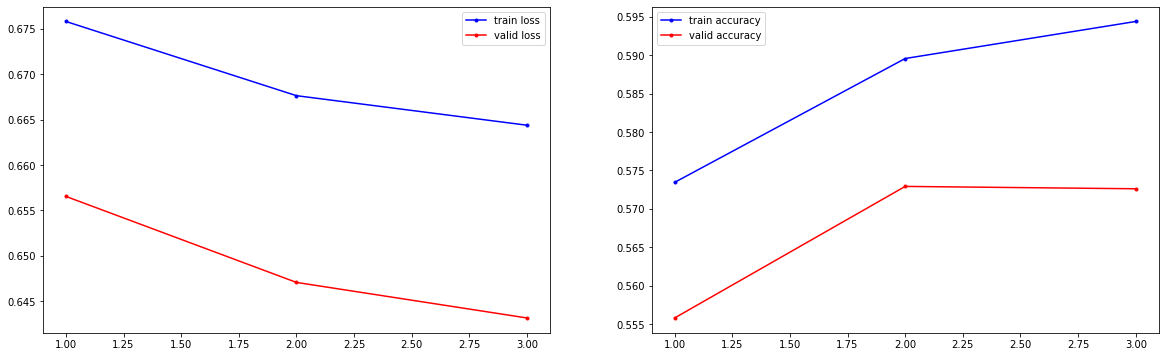

In [21]:
plot_training_classification(run_hist)

In [22]:
for param in model.named_parameters():
  print(param)


('rnn.weight_ih_l0', Parameter containing:
tensor([[ 4.2727e-02, -3.7077e-01, -3.2304e-01, -1.3599e-01],
        [-3.1113e-01, -1.3764e-01,  3.9581e-01,  6.8304e-02],
        [-3.1683e-01,  1.3472e-01,  3.2268e-02,  1.3676e-03],
        [-4.1178e-01,  4.9620e-02, -3.9946e-03, -1.5692e-02],
        [-1.8564e-01, -6.9797e-02, -5.8592e-03,  2.4092e-02],
        [-3.9544e-01, -6.9007e-02,  2.5157e-01,  8.3176e-02],
        [-3.3864e-01, -1.1904e-01, -1.0779e-01, -1.7974e-01],
        [ 7.1393e-01,  1.6317e-01, -2.0063e-02,  5.8883e-03],
        [-2.9443e-01, -5.1977e-02, -7.4965e-02,  1.1100e-01],
        [ 2.5657e-01,  8.0032e-02, -1.0539e-02,  1.7689e-02],
        [-5.1401e-01, -3.9779e-01, -2.0769e-02, -1.2474e-01],
        [ 1.0681e-01,  1.5499e-02, -4.3173e-02,  4.0050e-02],
        [ 6.4894e-01, -3.1844e-01,  4.8027e-01,  9.3268e-02],
        [ 5.8967e-01, -7.2563e-02, -2.4579e-03,  2.5582e-03],
        [-4.0940e-01, -1.8730e-01, -2.2015e-02, -3.3464e-01],
        [ 8.1269e-02,  2.08

In [23]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".RNN_1.pt")


In [24]:
model.to(device)

RNNUpgradeTracking(
  (rnn): LSTM(4, 14, num_layers=3, batch_first=True)
  (decoder): Linear(in_features=14, out_features=2, bias=True)
)

In [25]:
def make_prediction(dataloader, model):
    model.eval() 
    outputs = []
    batch_iterator = tqdm(iter(dataloader), leave=False, total=len(dataloader))
    for i, batch in enumerate(dataloader):
            inputs, _ = batch
            inputs = inputs.to(device)
            logits = model(inputs.float())
            outputs.append(logits.detach().cpu())
    logits = torch.cat(outputs)
    probas = torch.softmax(logits, dim=1)
    return probas

In [32]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist= run_hist, num_epochs=15)


Epoch 1/15
----------


train loss: 0.6552, train acc: 0.6054, elapsed:420.4344


valid loss: 0.6441, valid acc: 0.5705, elapsed:33.5936

Epoch 2/15
----------


train loss: 0.6547, train acc: 0.6061, elapsed:409.3473


valid loss: 0.6549, valid acc: 0.5412, elapsed:33.2750

Epoch 3/15
----------


train loss: 0.6545, train acc: 0.6061, elapsed:415.6487


valid loss: 0.6606, valid acc: 0.5337, elapsed:33.7106

Epoch 4/15
----------


train loss: 0.6542, train acc: 0.6064, elapsed:410.4019


valid loss: 0.6480, valid acc: 0.5374, elapsed:34.1678

Epoch 5/15
----------


train loss: 0.6540, train acc: 0.6069, elapsed:414.9865


valid loss: 0.6675, valid acc: 0.5362, elapsed:33.8012

Epoch 6/15
----------


train loss: 0.6539, train acc: 0.6069, elapsed:412.8853


valid loss: 0.6373, valid acc: 0.5654, elapsed:34.5025

Epoch 7/15
----------


train loss: 0.6534, train acc: 0.6074, elapsed:412.4722


valid loss: 0.6490, valid acc: 0.5581, elapsed:34.3996

Epoch 8/15
----------


train loss: 0.6527, train acc: 0.6085, elapsed:419.9163


valid loss: 0.6550, valid acc: 0.5452, elapsed:34.6365

Epoch 9/15
----------


train loss: 0.6527, train acc: 0.6085, elapsed:415.0260


valid loss: 0.6653, valid acc: 0.5136, elapsed:34.1276

Epoch 10/15
----------


train loss: 0.6524, train acc: 0.6090, elapsed:407.6246


valid loss: 0.6607, valid acc: 0.5300, elapsed:34.7800

Epoch 11/15
----------


train loss: 0.6516, train acc: 0.6096, elapsed:411.7227


valid loss: 0.6609, valid acc: 0.5341, elapsed:34.0408

Epoch 12/15
----------


train loss: 0.6515, train acc: 0.6099, elapsed:408.6875


valid loss: 0.6552, valid acc: 0.5526, elapsed:35.4640

Epoch 13/15
----------


train loss: 0.6513, train acc: 0.6100, elapsed:414.1335


valid loss: 0.6418, valid acc: 0.5679, elapsed:35.3564

Epoch 14/15
----------


train loss: 0.6510, train acc: 0.6102, elapsed:408.4455


valid loss: 0.6536, valid acc: 0.5554, elapsed:34.4816

Epoch 15/15
----------


train loss: 0.6505, train acc: 0.6109, elapsed:418.7329


valid loss: 0.6340, valid acc: 0.5933, elapsed:35.3439
training took:  6716.154227311723


In [34]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".RNN_1.pt")


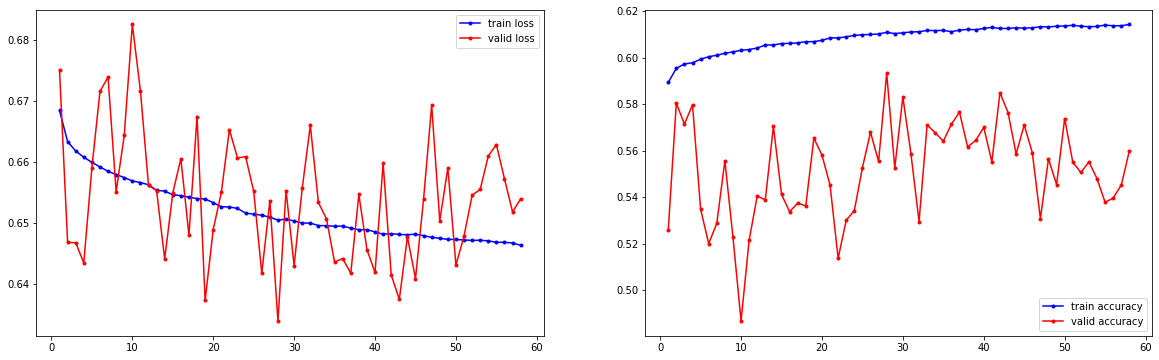

In [37]:
plot_training_classification(run_hist)

In [35]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist= run_hist, num_epochs=30)


Epoch 1/30
----------


train loss: 0.6507, train acc: 0.6103, elapsed:416.4205


valid loss: 0.6553, valid acc: 0.5525, elapsed:35.5111

Epoch 2/30
----------


train loss: 0.6504, train acc: 0.6107, elapsed:411.6752


valid loss: 0.6431, valid acc: 0.5831, elapsed:35.5488

Epoch 3/30
----------


train loss: 0.6500, train acc: 0.6110, elapsed:407.7336


valid loss: 0.6557, valid acc: 0.5586, elapsed:34.5937

Epoch 4/30
----------


train loss: 0.6500, train acc: 0.6112, elapsed:408.6864


valid loss: 0.6660, valid acc: 0.5295, elapsed:35.6593

Epoch 5/30
----------


train loss: 0.6496, train acc: 0.6117, elapsed:408.1206


valid loss: 0.6534, valid acc: 0.5711, elapsed:35.9748

Epoch 6/30
----------


train loss: 0.6496, train acc: 0.6117, elapsed:406.0291


valid loss: 0.6507, valid acc: 0.5676, elapsed:35.8465

Epoch 7/30
----------


train loss: 0.6495, train acc: 0.6117, elapsed:409.5733


valid loss: 0.6436, valid acc: 0.5640, elapsed:36.3895

Epoch 8/30
----------


train loss: 0.6495, train acc: 0.6112, elapsed:405.1078


valid loss: 0.6442, valid acc: 0.5714, elapsed:34.6399

Epoch 9/30
----------


train loss: 0.6492, train acc: 0.6118, elapsed:421.6457


valid loss: 0.6418, valid acc: 0.5765, elapsed:35.5430

Epoch 10/30
----------


train loss: 0.6489, train acc: 0.6122, elapsed:407.6206


valid loss: 0.6547, valid acc: 0.5616, elapsed:35.3262

Epoch 11/30
----------


train loss: 0.6489, train acc: 0.6121, elapsed:407.4277


valid loss: 0.6457, valid acc: 0.5644, elapsed:35.8086

Epoch 12/30
----------


train loss: 0.6486, train acc: 0.6126, elapsed:415.2058


valid loss: 0.6419, valid acc: 0.5700, elapsed:35.6420

Epoch 13/30
----------


train loss: 0.6482, train acc: 0.6130, elapsed:414.3690


valid loss: 0.6598, valid acc: 0.5551, elapsed:34.7857

Epoch 14/30
----------


train loss: 0.6483, train acc: 0.6126, elapsed:409.7632


valid loss: 0.6415, valid acc: 0.5850, elapsed:33.8815

Epoch 15/30
----------


train loss: 0.6481, train acc: 0.6126, elapsed:405.8272


valid loss: 0.6375, valid acc: 0.5764, elapsed:34.2451

Epoch 16/30
----------


train loss: 0.6481, train acc: 0.6129, elapsed:410.5564


valid loss: 0.6477, valid acc: 0.5586, elapsed:34.2125

Epoch 17/30
----------


train loss: 0.6482, train acc: 0.6127, elapsed:398.1670


valid loss: 0.6409, valid acc: 0.5710, elapsed:34.5910

Epoch 18/30
----------


train loss: 0.6480, train acc: 0.6128, elapsed:417.1411


valid loss: 0.6539, valid acc: 0.5591, elapsed:34.3510

Epoch 19/30
----------


train loss: 0.6477, train acc: 0.6133, elapsed:398.9322


valid loss: 0.6693, valid acc: 0.5307, elapsed:35.0385

Epoch 20/30
----------


train loss: 0.6475, train acc: 0.6133, elapsed:406.6262


valid loss: 0.6504, valid acc: 0.5564, elapsed:35.4275

Epoch 21/30
----------


train loss: 0.6473, train acc: 0.6135, elapsed:405.1429


valid loss: 0.6591, valid acc: 0.5454, elapsed:34.6441

Epoch 22/30
----------


train loss: 0.6473, train acc: 0.6136, elapsed:407.7414


valid loss: 0.6431, valid acc: 0.5738, elapsed:34.9062

Epoch 23/30
----------


train loss: 0.6472, train acc: 0.6139, elapsed:400.7044


valid loss: 0.6479, valid acc: 0.5550, elapsed:34.2270

Epoch 24/30
----------


train loss: 0.6472, train acc: 0.6135, elapsed:416.2550


valid loss: 0.6546, valid acc: 0.5506, elapsed:34.6513

Epoch 25/30
----------


train loss: 0.6472, train acc: 0.6133, elapsed:397.4365


valid loss: 0.6555, valid acc: 0.5551, elapsed:35.1107

Epoch 26/30
----------


train loss: 0.6471, train acc: 0.6134, elapsed:410.7838


valid loss: 0.6610, valid acc: 0.5479, elapsed:34.7263

Epoch 27/30
----------


train loss: 0.6469, train acc: 0.6140, elapsed:402.9216


valid loss: 0.6629, valid acc: 0.5377, elapsed:34.7334

Epoch 28/30
----------


train loss: 0.6469, train acc: 0.6137, elapsed:405.3342


valid loss: 0.6573, valid acc: 0.5396, elapsed:34.9989

Epoch 29/30
----------


train loss: 0.6467, train acc: 0.6137, elapsed:401.3810


valid loss: 0.6518, valid acc: 0.5452, elapsed:35.2606

Epoch 30/30
----------


train loss: 0.6464, train acc: 0.6143, elapsed:398.7452


valid loss: 0.6540, valid acc: 0.5600, elapsed:35.1332
training took:  13284.49905347405


In [38]:
learning_rate = 1e-5
optimizer_2 = torch.optim.Adam(model.parameters(), lr=learning_rate)